In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from gensim.models import Word2Vec as wv

%load_ext autoreload
%matplotlib inline

module_path = os.path.abspath(os.path.join('./syn_ant_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import model_dataset as dataset 
import model_functions_PhaseI as functions
import model_morphology as morpho
import model_testing_PhaseI as test 
import model_training_PhaseI as train

torch.manual_seed(28)

In [2]:
word_pairs_df = pd.read_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')
word_pairs_df

,Unnamed: 0,word 1,word 2,label
0,0,infinite,bounded,2
1,1,infinite,brief,2
2,2,infinite,calculable,0
3,3,infinite,ceasing,2
4,4,infinite,ending,2
...,...,...,...,...
14227,14227,charm,fascinate,1
14228,14228,charm,magical spell,1
14229,14229,charm,appealingness,1
14230,14230,charm,enchant,1


In [3]:
word_pairs_df['label'].value_counts()

1    6534
0    4696
2    3002
Name: label, dtype: int64

In [4]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

w2v_model_path = '/Users/wesleytatum/Desktop/post_doc/data/w2v_models/200D_all_abstracts_model/full_corpus_w2v_mc5_s200_wdw10.model'
model1 = wv.load(w2v_model_path)
vocabulary1 = list(model1.wv.vocab)
print(f'w2v vocab length: {len(vocabulary1)}')

w2v_data_df = word_pairs_df.copy()

#finding which words are in the pd but not in vocabulary1
list1 = list(word_pairs_df['word 1'])
list2 = list(word_pairs_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))
print(f'number of word pair words: {len(list(set(list1+list2)))}')
print(f'number of missing words: {len(missing)}')

#keeping only the rows in the pd that have words in vocabulary1
w2v_data_df = w2v_data_df[~w2v_data_df['word 1'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['word 2'].isin(missing)]

#reseting indeces after mask
w2v_data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)
print(f'length of common vocab: {len(common)}')


w2v vocab length: 358151
number of word pair words: 9043
number of missing words: 2322
length of common vocab: 6733


In [5]:
#save vocab list and call it in the Pre_Trained_Embeddings
common_df = pd.DataFrame(common)
common_df.to_csv('./data/words_list.csv', index=False)


In [6]:
#for word pairs in our proposed training set, check if both words are in
#the common vocabulary list and then create a new dataframe with their indices

w2v_indx_df = pd.DataFrame(columns = ['word 1', 'word 2', 'label'])

pbar = tqdm(total = len(w2v_data_df), position = 0)

for i in range(len(w2v_data_df)):
    
    word1 = w2v_data_df['word 1'].iloc[i]
    word2 = w2v_data_df['word 2'].iloc[i]
    label = w2v_data_df['label'].iloc[i]
    
    if word1 in common:
        if word2 in common:
            index1 = common.index(word1)
            index2 = common.index(word2)
            w2v_indx_df.loc[i] = pd.Series({'word 1':index1, 'word 2':index2, 'label':label})
        else:
            pass
    else:
        pass
    pbar.update()
    
w2v_indx_df

100%|█████████▉| 10885/10916 [00:27<00:00, 379.64it/s]

,word 1,word 2,label
0,3140,663,2
1,3140,696,2
2,3140,763,0
3,3140,842,2
4,3140,2071,2
...,...,...,...
10911,3701,356,1
10912,3701,3700,1
10913,3701,3258,1
10914,891,2362,1


100%|██████████| 10916/10916 [00:40<00:00, 379.64it/s]

In [7]:
w2v_indx_df.label.value_counts()

1    4668
0    4001
2    2247
Name: label, dtype: int64

In [8]:
X = w2v_indx_df[['word 1', 'word 2']]
Y = w2v_indx_df['label']

xtr, xts, ytr, yts = train_test_split(X, Y, test_size = 0.2, shuffle = True)

xtr_tens = torch.from_numpy(xtr.values.astype(float))
xts_tens = torch.from_numpy(xts.values.astype(float))
ytr_tens = torch.tensor(ytr.values.astype(float))
yts_tens = torch.tensor(yts.values.astype(float))

xtr_tens = xtr_tens.type(torch.long)
xts_tens = xts_tens.type(torch.long)
ytr_tens = ytr_tens.type(torch.long)
yts_tens = yts_tens.type(torch.long)

train_set = TensorDataset(xtr_tens, ytr_tens)
test_set = TensorDataset(xts_tens, yts_tens)

In [9]:
print(torch.unique(yts_tens))

tensor([0, 1, 2])


In [10]:
#Hyper parameters
num_epochs = 30
batch_size = 50
learning_rate = 1e-4

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [11]:
%autoreload

vocab_length = len(common)+1 #+1 avoids indexing error
print(f'vocabulary length = {vocab_length}')

# Instantiate NN model. 'in_dims' = dimensions of embeddings in 'common'
model = morpho.Phase_I_NN(in_dims = 200,
                          vocab_length = vocab_length,
                          common = common,
                          w2v_model = model1).to(device)
model.apply(functions.init_weights)

#define the optimizer
optimizer = torch.optim.AdamW(params = model.parameters(),
                              lr = learning_rate,
                              amsgrad = True)

vocabulary length = 6734


In [12]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []

syn_train_epoch_accuracies = []
ant_train_epoch_accuracies = []
irrel_train_epoch_accuracies = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []

syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []
irrel_test_epoch_accuracies = []

pbar = tqdm(total = num_epochs, position = 0)

for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, Lm_train_epoch_loss, train_syn_epoch_acc, train_ant_epoch_acc, train_irrel_epoch_acc = train.Phase_I_train_model(model = model, training_data_set = train_loader, optimizer = optimizer)
        
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
    syn_train_epoch_accuracies.append(train_syn_epoch_acc)
    ant_train_epoch_accuracies.append(train_ant_epoch_acc)
    irrel_train_epoch_accuracies.append(train_irrel_epoch_acc)
       
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, Lm_test_epoch_loss, syn_epoch_acc, ant_epoch_acc, irrel_epoch_acc, syn_true, syn_predictions, ant_true, ant_predictions = test.Phase_I_eval_model(model = model, testing_data_set = test_loader, optimizer = optimizer)
        
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    irrel_test_epoch_accuracies.append(irrel_epoch_acc)

    pbar.update()

100%|██████████| 30/30 [05:53<00:00, 11.85s/it]

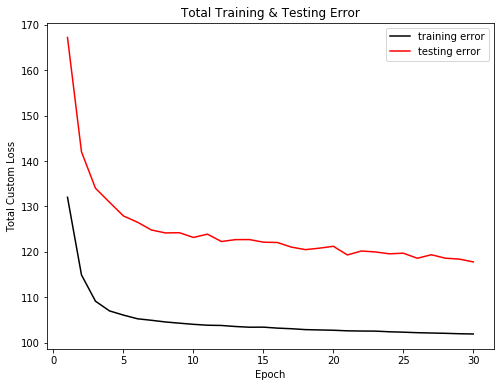

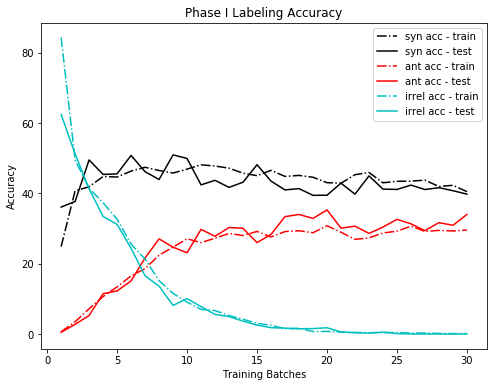

In [13]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_train_epoch_accuracies, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn acc - test')
plt.plot(epochs, ant_train_epoch_accuracies, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant acc - test')
plt.plot(epochs, irrel_train_epoch_accuracies, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, irrel_test_epoch_accuracies, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Training Batches')
ax.set_ylabel('Accuracy')
plt.show()

In [ ]:
#thresholding the predicted values to be compared to the labels
syn_predictions = list(map(lambda x:1 if x >= 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:-1 if x <= -0.8 else x, syn_predictions))

ant_predictions = list(map(lambda x:1 if x >= 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:-1 if x <= -0.8 else x, ant_predictions))


#synonymy confusion matrix
syn_matrix = confusion_matrix(syn_true, syn_predictions)

#antonymy confusion matrix
ant_matrix = confusion_matrix(ant_true, ant_predictions)

In [ ]:
syn_matrix

In [ ]:
ant_matrix